In [1]:
from pathlib import Path
from dotenv import load_dotenv
import os
import numpy as np
import json
import sys

notebook_path = Path().resolve()
project_root = notebook_path.parent
sys.path.insert(0, str(project_root))

from tools.body_parts_map import body_parts_map

load_dotenv()

dataset_path = Path(os.getenv("DATASET_PATH"))

In [2]:
keypoint_nan_ratios = []
motion_feature_nan_ratios = {"violin": [], "mridangam": [], "vocal": []}
scores = {"violin": [], "mridangam": [], "vocal": []}
for artist in os.listdir(dataset_path):
    if not os.path.isdir(os.path.join(dataset_path, artist)):
        continue
    for song in os.listdir(os.path.join(dataset_path, artist)):
        song_dir = os.path.join(dataset_path, artist, song)
        for instrument in os.listdir(song_dir):
            instrument_dir = os.path.join(song_dir, instrument)
            if not os.path.isdir(instrument_dir):
                continue

            keypoint_scores_file = os.path.join(
                instrument_dir, "keypoint_scores.npy"
            )
            keypoint_scores = np.load(keypoint_scores_file, allow_pickle=True)
            keypoint_scores = keypoint_scores[:, :, 0]
            scores[instrument].append(keypoint_scores)
            all_nans = np.all(np.isnan(keypoint_scores), axis=1)
            nan_ratio = np.sum(all_nans) / len(all_nans)
            keypoint_nan_ratios.append(nan_ratio)

            motion_feature_file = os.path.join(
                instrument_dir, "motion_features.json"
            )
            with open(motion_feature_file, "r") as f:
                motion_features = json.load(f)
            mean_speed = np.array(motion_features["general"]["mean_speed"])
            mean_acceleration = np.array(
                motion_features["general"]["mean_acceleration"]
            )
            mean_speed_nan_ratio = np.sum(np.isnan(mean_speed)) / len(
                mean_speed
            )
            mean_acceleration_nan_ratio = np.sum(
                np.isnan(mean_acceleration)
            ) / len(mean_acceleration)
            motion_feature_nan_ratios[instrument].append(
                (mean_speed_nan_ratio, mean_acceleration_nan_ratio)
            )

average_keypoint_nan_ratio = np.mean(keypoint_nan_ratios)
print(
    f"Average NaN ratio across all keypoint scores: {average_keypoint_nan_ratio:.4f}"
)

average_motion_feature_nan_ratios = {
    instrument: np.mean(
        [np.mean(ratios) for ratios in motion_feature_nan_ratios[instrument]]
    )
    for instrument in motion_feature_nan_ratios
}
print("\nAverage NaN ratios for motion features:")
for instrument, ratios in average_motion_feature_nan_ratios.items():
    print(f"{instrument}: {ratios:.4f}")

average_scores = {}

for instrument, score_list in scores.items():
    all_scores = np.concatenate(
        score_list, axis=0
    )  # shape (total_X, 133, 1) or (total_X, 133)
    avg_score = np.nanmean(np.nanmean(all_scores, axis=0))
    average_scores[instrument] = avg_score

print("\nAverage scores for each instrument:")
# Print average scores
for instrument, avg in average_scores.items():
    print(f"{instrument}: {avg if avg is not None else 'No data'}")

Average NaN ratio across all keypoint scores: 0.0167

Average NaN ratios for motion features:
violin: 0.0002
mridangam: 0.0714
vocal: 0.0005

Average scores for each instrument:
violin: 6.824155807495117
mridangam: 6.639289855957031
vocal: 8.392308235168457


In [3]:
with open(os.path.join(dataset_path, "dataset_metadata.json"), "r") as f:
    dataset_metadata = json.load(f)

In [4]:
filtered_scores = {"violin": [], "mridangam": [], "vocal": []}
for artist in os.listdir(dataset_path):
    if not os.path.isdir(os.path.join(dataset_path, artist)):
        continue
    for song in os.listdir(os.path.join(dataset_path, artist)):
        song_dir = os.path.join(dataset_path, artist, song)
        layout = (
            dataset_metadata.get(artist, {}).get(song, {}).get("layout", {})
        )
        if len(layout) == 3:
            for i, instrument in enumerate(layout):
                instrument_dir = os.path.join(song_dir, instrument)
                if not os.path.isdir(instrument_dir):
                    continue

                keypoint_scores_file = os.path.join(
                    instrument_dir, "keypoint_scores.npy"
                )
                keypoint_scores = np.load(
                    keypoint_scores_file, allow_pickle=True
                )
                keypoint_scores = np.delete(
                    keypoint_scores, np.s_[11:23], axis=1
                )
                keypoints_to_remove = []
                if i == 0:
                    keypoints_to_remove = body_parts_map["left_arm"]
                    keypoints_to_remove.extend(body_parts_map["left_hand"])
                elif i == 2:
                    keypoints_to_remove = body_parts_map["right_arm"]
                    keypoints_to_remove.extend(body_parts_map["right_hand"])

                keypoints_to_remove = list(set(keypoints_to_remove))
                keypoint_scores = np.delete(
                    keypoint_scores,
                    np.s_[keypoints_to_remove],
                    axis=1,
                )
                keypoint_scores = keypoint_scores[:, :, 0]
                filtered_scores[instrument].append(keypoint_scores)

filtered_average_scores = {}
for instrument, score_list in filtered_scores.items():
    # average scores across all songs for each instrument, the scores for each instrument have different number of keypoints
    all_scores = np.concatenate(score_list, axis=0)
    avg_score = np.nanmean(np.nanmean(all_scores, axis=0))
    filtered_average_scores[instrument] = avg_score
print("\nFiltered average scores for each instrument:")
for instrument, avg in filtered_average_scores.items():
    print(f"{instrument}: {avg if avg is not None else 'No data'}")


Filtered average scores for each instrument:
violin: 7.743643760681152
mridangam: 7.690756320953369
vocal: 8.820884704589844


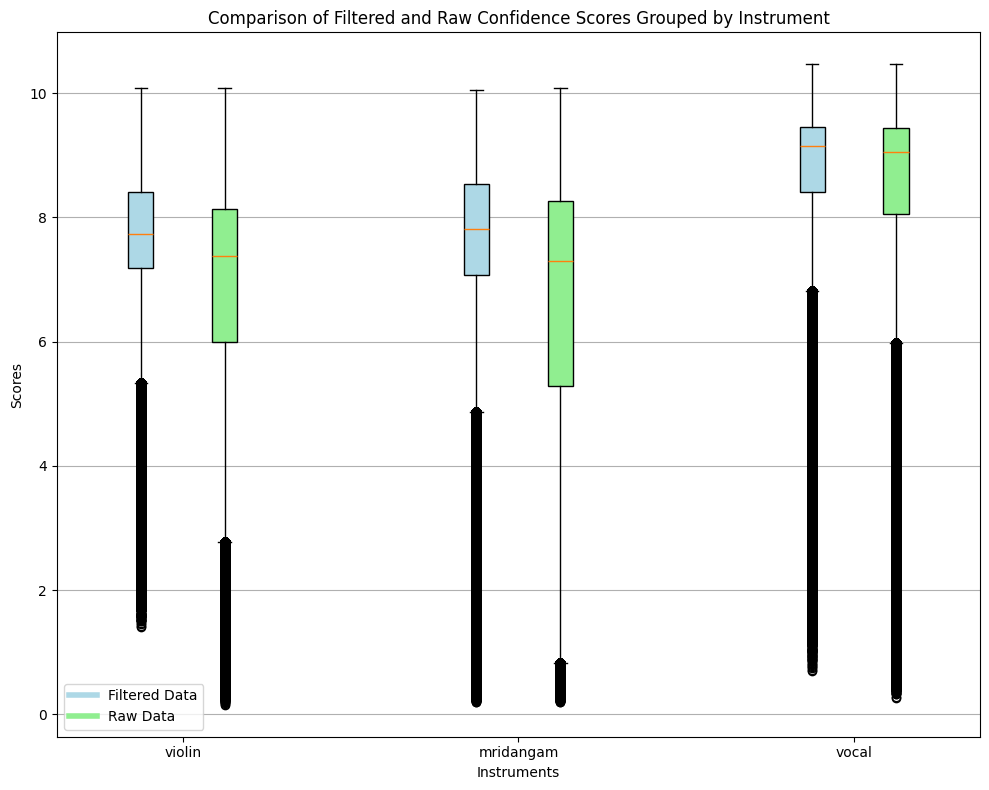

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for grouped boxplots by instrument
grouped_data = []
grouped_labels = []
for instrument in filtered_scores.keys():
    # Combine filtered and raw scores for the same instrument
    instrument_data = [
        np.concatenate(filtered_scores[instrument], axis=0).flatten()[
            ~np.isnan(
                np.concatenate(filtered_scores[instrument], axis=0).flatten()
            )
        ],
        np.concatenate(scores[instrument], axis=0).flatten()[
            ~np.isnan(np.concatenate(scores[instrument], axis=0).flatten())
        ],
    ]
    grouped_data.append(instrument_data)
    grouped_labels.append(instrument)

# Create grouped boxplots by instrument
plt.figure(figsize=(10, 8))
colors = ["lightblue", "lightgreen"]  # Colors for filtered and raw data
for i, (data, label) in enumerate(zip(grouped_data, grouped_labels)):
    positions = [2 * i + 1, 2 * i + 1.5]  # Adjust positions for closer groups
    boxplots = plt.boxplot(
        data,
        positions=positions,
        patch_artist=True,
        tick_labels=[f"{label} (Filtered)", f"{label} (Raw)"],
    )
    for patch, color in zip(boxplots["boxes"], colors):
        patch.set_facecolor(color)

# Add legend for colors
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="lightblue", lw=4, label="Filtered Data"),
        plt.Line2D([0], [0], color="lightgreen", lw=4, label="Raw Data"),
    ],
    loc="lower left",
)

plt.title(
    "Comparison of Filtered and Raw Confidence Scores Grouped by Instrument"
)
plt.ylabel("Scores")
plt.xlabel("Instruments")
plt.xticks(
    [2 * i + 1.25 for i in range(len(grouped_labels))],  # Adjust x-ticks
    grouped_labels,
)
plt.grid(axis="y")
plt.tight_layout()
plt.show()